### Detección de bordes en una imagen
La deteción de bordes es una técnica en el procesamiento de imagenes con el fin de destacar elementos presentes en la imagen pero que no se logran visualizar con detalle. Este algoritmo resalta los puntos en los cuales el brillo de la imagen cambia bruscamente produciendo discontinuidades.

El proposito de la detección de bordes es reducir la cantidad de información de una imagen conservando la estructura de los objetos en ella. 

Existen diferentess métodos con los cuales se puede obtener este resultado, el primero y más básico es el uso del operador gradiente, el cual esta definido de la siguiente manera:

\begin{equation*}
\nabla I(i,j) = \frac{\partial I(i,j)}{\partial i} \hat{i} + \frac{\partial I(i,j)}{\partial j} \hat{j}
\end{equation*}

este al ser un vector, se pueden definir su magnitud y dirección, los cuales se computan de la siguiente manera:

\begin{equation*}
|G|=\sqrt{\left(\frac{\partial I}{\partial i}\right)^2+\left(\frac{\partial I}{\partial j}\right)^2} \\qquad
\end{equation*}

\begin{equation*}
\theta = tan^{-1}\left(\frac{G_j}{G_i} \right)
\end{equation*}

Los operadores clásicos usados en estos algoritmo son los de Robert, Sobel y Prewitt, los cuales a pesar de que su uso sea sencillo, pueden obtener una alta sensibilidad a las discontinuidades en el brillo.

Operadores de Sobel


\begin{equation*}
D_x = \left[\begin{matrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 
\end{matrix} \right] 
\, \, \,
D_y = \left[\begin{matrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 
\end{matrix} \right]
\end{equation*}

Operadores de Prewitt

\begin{equation*}
D_x = \left[\begin{matrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 
\end{matrix} \right] 
\, \, \,
D_y = \left[\begin{matrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1 
\end{matrix} \right]
\end{equation*}

Al tener un operador definido, se procese a realizar el algoritmo de convolusión el cual esta definido de la siguiente manera:

\begin{equation*}
C[i,j]= \sum_n \sum_m A[i-n,j-m]O[n,m]
\end{equation*}

donde A es la matriz de la imagen y O es el operador, de esta manera no ess muy visual su funcionamiento. Este puede verse a más detalle con el siguiente ejemplo:
http://www.songho.ca/dsp/convolution/convolution2d_example.html

Esta operación ya se encuentra definida en la libreria de scipy, y la manera de usarla es de la siguiente manera:

````
result = scipy.signal.convolve2d(imagen, operador)
````

In [6]:
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
import numpy as np
import cv2

In [72]:
class edge_detection:
    def __init__(self, kernel_name, path_image, name_image):
        self.kernel_name = kernel_name
        self.path_image = path_image
        self.name_image = name_image
        self.kernel_define()
        self.read_image()
        self.convolve_images()

    def kernel_define(self):
        """
        Kernel (matriz de transformacion) para la deteccion de bordes en imagenes
        de alta resolución
        """
        kernels = {
            "Sobel": [
                [-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1],
            ],
            "Prewitt": [
                [-1, -1, -1],
                [0, 0, 0],
                [1, 1, 1],
            ],
            "Feldman": [
                [10, 10, 20, 10, 10],
                [3, 3, 10, 3, 3],
                [0, 0, 0, 0, 0],
                [-3, -3, -10, -3, -3],
                [-10, -10, -20, -10, -10],
            ],
            "Scharr": [
                [47, 162, 47],
                [0, 0, 0],
                [-47, -162, -47],
            ],
        }
        self.kernel = np.array(kernels[self.kernel_name])

    def read_image(self):
        """
        Lectura de la imagen y aplicacion del filtro de alto contraste
        """
        img_original = cv2.imread(self.path_image + self.name_image, 1)
        self.img = self.high_contrast_image(img_original)[:, :, 0]
        self.img_original = Image.open(self.path_image +
                                       self.name_image).convert("RGB")

    def high_contrast_image(self, img):
        """
        Funcion que aplica el alto contraste a la imagen cargada.
        Este processo no ess necesario, es solo para obtener mejores
        resultados
        """
        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8, 8))
        # convert from BGR to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)  # split on 3 different channels
        l2 = clahe.apply(l)  # apply CLAHE to the L-channel
        lab = cv2.merge((l2, a, b))  # merge channels
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
        return img

    def convolve_images(self):
        """
        Proceso de convolución (multiplicacion de matrices) en la imagen con el kernel
        seleccionado
        """
        img_edge_x = signal.convolve2d(self.img,
                                       self.kernel,
                                       boundary='symm',
                                       mode='same')
        img_edge_y = signal.convolve2d(self.img,
                                       self.kernel.transpose(),
                                       boundary='symm',
                                       mode='same')
        self.img_edge = np.sqrt(img_edge_x**2 + img_edge_y**2)

    def plot_image(self, name_result="result.png", path="", save_image=False):
        """
        Función que grafica las dos imagenes en una sola, de lado izquierdo la original
        y de lado derecho con bordes
        """
        images = [self.img_original, self.img_edge]
        fig = plt.figure(figsize=(13, 5))
        axs = [fig.add_subplot(1, 2, i + 1) for i in range(2)]
        axs = np.reshape(axs, 2)
        plt.subplots_adjust(left=0,
                            bottom=0,
                            right=1,
                            top=0.957,
                            wspace=0,
                            hspace=0)
        for ax, image in zip(axs, images):
            self.individual_plots(ax, image)
        if save_image:
            plt.savefig(path_result + name_result,
                        bbox_inches="tight",
                        pad_inches=0)
        else:
            plt.show()

    def individual_plots(self, ax, image):
        #Ploteo de cada imagen
        ax.axis("off")
        ax.imshow(image, cmap="gray")

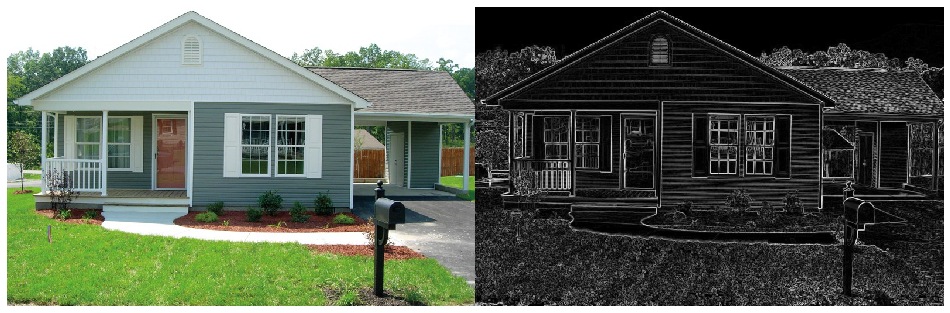

In [73]:
path=""
name="image.jpg"
kernel="Sobel"
border=edge_detection(kernel,path,name)
border.plot_image()

Referencias: Nota 

!!CUIDADO!!

Ejemplos:

http://www.boletin.upiita.ipn.mx/index.php/ciencia/669-cyt-numero-55/1293-extraccion-de-bordes-operadores-sobel-prewitt-y-roberts

https://www.researchgate.net/publication/283766898_Algorithm_and_Technique_on_Various_Edge_Detection_A_Survey

Referencia:


+ García Arellano, A. (2007). Adelgazamiento y Detección de Bordes de Objetos en Imágenes Digitales Usando Conjuntos Difusos. 1–132. 

+ S. Jayaraman. (2009). “Digital imagen processing,” New Delhi: Tata McGraw Hill, pp. 127–132

+ C. Solomon and T. Breckon. (2011). “Fundamentals of digital image processing,” Oxford: Wiley-Blackwell, pp. 97–103.

+ Ordoñez, J. F., & Oñate, L. (2016). Detector De Bordes De Imágenes Usando Un Microcontrolador Arm. Ingenius, 16, 30. https://doi.org/10.17163/ings.n16.2016.04